In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

np.random.seed(1)

# Define activation function

In [2]:
def sigmoid(Z):
    """
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

In [3]:
def relu(Z):
    """
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    A = np.maximum(0, Z)
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

In [4]:
def relu_backward(dA, cache):
    """
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [5]:
def sigmoid_backward(dA, cache):
    """
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    Z = cache
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [6]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """    
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters     

In [20]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in neural network
    
    Returns:
    parameters -- python dictionary containing parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims) # number of layer in neural network
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    
    return parameters

# Forward propagation
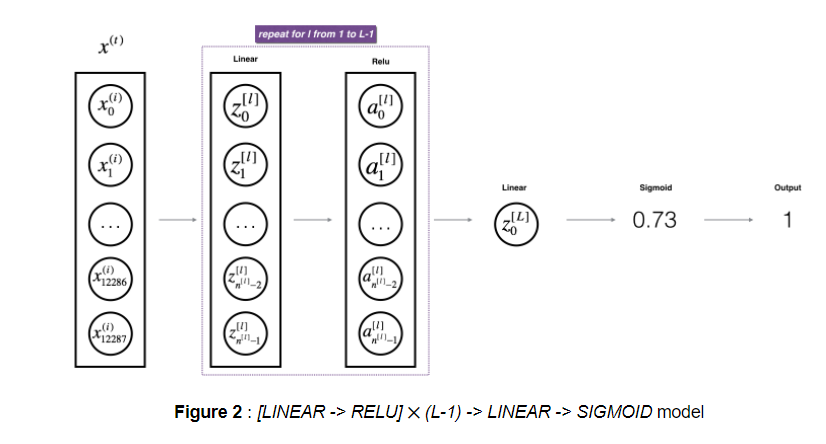

In [8]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [9]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == 'relu':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    elif activation == 'sigmoid':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [21]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2 #number of layers in neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
        
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
            
    return AL, caches

In [22]:
# Compute cost
def compute_cost(AL, Y):
    """
    Returns:
    cost -- binary-crossentropy
    """
    m = Y.shape[1]
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost

# Backward propagation
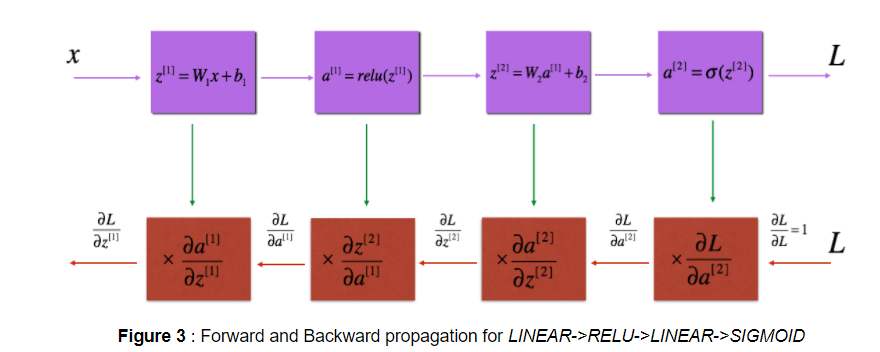

In [12]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis = 1).reshape(-1, 1)
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [13]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

# L-model backward
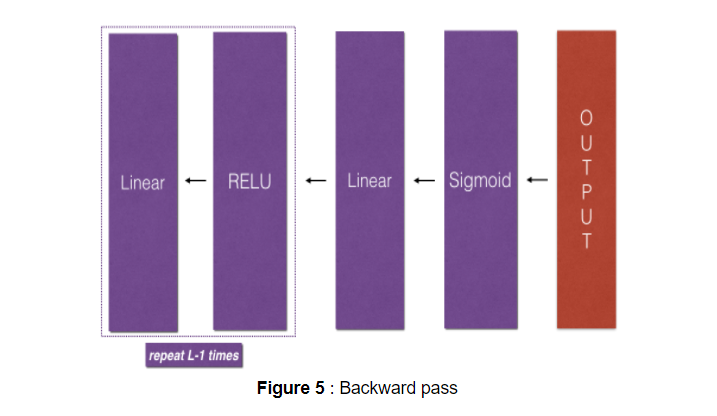

In [23]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1))
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of the layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # đạo hàm binary-crossentropy
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [15]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing parameters 
    grads -- python dictionary containing gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    L = len(parameters) // 2 # number of layers in the neural network
    
    for l in range(L):
        parameters["W" + str(l+1)] -= learning_rate * grads['dW' + str(l+1)]
        parameters["b" + str(l+1)] -= learning_rate * grads['db' + str(l+1)]
    
    return parameters